Run this notebook after the other notebooks in this directory and the `analysis/mutations.ipynb` notebook.

In [1]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from Bio.Data import CodonTable
from Bio.Seq import Seq

from passenger import CHIGY_HC_STOP_TRIMMED, CHIGY_LC_STOP_TRIMMED


In [2]:
# Provided by Gabriel:

grid_string = """
G27(H)V
D28(H){AVNGHY}
S59(H)R
S64(H)R
R80(H){LPQ}
Y103(H){SH}
A105(H)G
W118(H)S
Q27(L){RK}
A40(L){GS}
Q44(L){AE}
P50(L)T
A52(L)S
S56(L)A
S69(L)R
D74(L){YHVANG}
N108(L){KYHSTI}
S109(L)R
L116(L)I
"""

In [3]:
lines = [line.strip() for line in grid_string.split('\n') if line.strip()]

# Regular expression to match the pattern
pattern = r'([A-Z])(\d+)\(([A-Z])\)([A-Z{}]+)'

data = []
for line in lines:
    match = re.match(pattern, line)
    if match:
        initial_aa, site, chain, final_aas = match.groups()
        
        # Remove braces if they exist
        final_aas = final_aas.strip('{}')
        
        data.append({
            'initial_aa': initial_aa,
            'IMGT_site': int(site),
            'chain': chain,
            'final_aas': final_aas
        })

# Create DataFrame and sort by chain and site
subs_df = pd.DataFrame(data)
subs_df = subs_df.sort_values(['chain', 'IMGT_site'])
subs_df["chain_IMGT_site"] = subs_df["chain"] + subs_df["IMGT_site"].astype(str)
subs_df

,initial_aa,IMGT_site,chain,final_aas,chain_IMGT_site
0,G,27,H,V,H27
1,D,28,H,AVNGHY,H28
2,S,59,H,R,H59
3,S,64,H,R,H64
4,R,80,H,LPQ,H80
5,Y,103,H,SH,H103
6,A,105,H,G,H105
7,W,118,H,S,H118
8,Q,27,L,RK,L27
9,A,40,L,GS,L40


First set up "python" indexing, which is going to be 0-based codon indexing from the start of the chain.

In [4]:
dms_sites = "../analysis/data/dms/CGGnaive_sites.csv"
pos_df = pd.read_csv(dms_sites, dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
indexing_df = pos_df[["site", "chain"]].reset_index()
indexing_df = indexing_df.rename(columns={"site_scFv": "python_site", "site": "IMGT_site"})
indexing_df = indexing_df.dropna()

# Move to 0-indexing
indexing_df["python_site"] = indexing_df["python_site"] - 1
# find the index of the first light chain site
first_light_chain_site = indexing_df[indexing_df["chain"] == "L"]["python_site"].min()
# subtract first_light_chain_site from all light chain sites
indexing_df.loc[indexing_df["chain"] == "L", "python_site"] -= first_light_chain_site
# let subs_df be the merge of subs_df and indexing_df on chain and IMGT_site
subs_df = subs_df.merge(indexing_df, on=["chain", "IMGT_site"], how="left")
subs_df


,initial_aa,IMGT_site,chain,final_aas,chain_IMGT_site,python_site
0,G,27,H,V,H27,25
1,D,28,H,AVNGHY,H28,26
2,S,59,H,R,H59,53
3,S,64,H,R,H64,55
4,R,80,H,LPQ,H80,70
5,Y,103,H,SH,H103,93
6,A,105,H,G,H105,95
7,W,118,H,S,H118,101
8,Q,27,L,RK,L27,26
9,A,40,L,GS,L40,33


Check that the naive amino acid identity syncs up with what we have in `CGGnaive_sites.csv`.

In [5]:
pos_df["chain_IMGT_site"] = pos_df["chain"] + pos_df["site"].astype(str)
compare_df = pd.merge(subs_df, pos_df, on="chain_IMGT_site", how="inner")
assert (compare_df["initial_aa"] == compare_df["amino_acid"]).all()

Second, check that our naive nucleotide sequence corresponds to the amino acid sequence in `CGGnaive_sites.csv`.

In [6]:
hc_codons = CHIGY_HC_STOP_TRIMMED[:len(CHIGY_HC_STOP_TRIMMED) // 3 * 3]
lc_codons = CHIGY_LC_STOP_TRIMMED[:len(CHIGY_LC_STOP_TRIMMED) // 3 * 3]

assert str(Seq(hc_codons).translate()) == "".join(pos_df.query("chain == 'H'")["amino_acid"])
# Note -1 to remove the last AA here.
assert str(Seq(lc_codons).translate()) == "".join(pos_df.query("chain == 'L'")["amino_acid"][:-1])

Next, set up codon retrieval.

In [7]:
def get_codon_from_python_site(seq, python_site):
    return seq[python_site*3:(python_site+1)*3]

def get_chigy_codon(chain, python_site):
    if chain == "H":
        return get_codon_from_python_site(hc_codons, python_site)
    elif chain == "L":
        return get_codon_from_python_site(lc_codons, python_site)
    else:
        raise ValueError(f"Invalid chain: {chain}")

# make a codon column using get_chigy_codon applied to rows of subs_df
subs_df["codon"] = subs_df.apply(lambda row: get_chigy_codon(row["chain"], row["python_site"]), axis=1)
subs_df["translated_codon"] = subs_df["codon"].apply(lambda codon: str(Seq(codon).translate()))

# assert that initial_aa is the same as translated_codon
assert (subs_df["initial_aa"] == subs_df["translated_codon"]).all()
# drop chain_imgt_site and translated_codon
subs_df = subs_df.drop(columns=["chain_IMGT_site", "translated_codon"])

subs_df.head()

,initial_aa,IMGT_site,chain,final_aas,python_site,codon
0,G,27,H,V,25,GGC
1,D,28,H,AVNGHY,26,GAC
2,S,59,H,R,53,AGT
3,S,64,H,R,55,AGC
4,R,80,H,LPQ,70,CGA


In [8]:
# Split final_aas into individual characters and melt
subs_df = (subs_df.assign(final_aa=subs_df['final_aas'].apply(list))
           .explode('final_aa')
           .drop('final_aas', axis=1)).reset_index(drop=True)


In [9]:
def get_codons_for_aa(aa):
    """Get all possible codons for a given amino acid using the standard genetic code."""
    standard_table = CodonTable.standard_dna_table
    return [codon for codon, amino in standard_table.forward_table.items() if amino == aa]

# Add the final_codons column to subs_df
subs_df['final_codons'] = subs_df['final_aa'].apply(get_codons_for_aa)

subs_df.head()

,initial_aa,IMGT_site,chain,python_site,codon,final_aa,final_codons
0,G,27,H,25,GGC,V,"[GTT, GTC, GTA, GTG]"
1,D,28,H,26,GAC,A,"[GCT, GCC, GCA, GCG]"
2,D,28,H,26,GAC,V,"[GTT, GTC, GTA, GTG]"
3,D,28,H,26,GAC,N,"[AAT, AAC]"
4,D,28,H,26,GAC,G,"[GGT, GGC, GGA, GGG]"


Now we load in the mutability dataframes.

In [10]:
igh_rates = pd.read_csv("output/chigy_hc_mutation_rates_nt.csv").drop(columns=["Unnamed: 0", "Fivemer"])
igl_rates = pd.read_csv("output/chigy_lc_mutation_rates_nt.csv").drop(columns=["Unnamed: 0", "Fivemer"])
igh_rates.head()

,A,C,G,T
0,0.000006,0.000006,0.000000,0.000006
1,0.000000,0.000006,0.000006,0.000006
2,0.001525,0.000632,0.000000,0.000093
3,0.000172,0.000090,0.000000,0.000008
4,0.000697,0.000294,0.000143,0.000000


In [11]:
def single_nt_rate(rates, python_codon_site, start_codon, end_codon):
    """
    Calculate rate for single nucleotide changes between codons.
    
    Args:
        rates: DataFrame with columns A, C, G, T containing mutation rates
        python_codon_site: int, the codon site index (will be multiplied by 3 for nucleotide position)
        start_codon: str, the starting codon (e.g., 'ATG')
        end_codon: str, the ending codon (e.g., 'CTG')
    
    Returns:
        float: mutation rate if codons differ by exactly one nucleotide, 0 otherwise
    """
    # Count differences between codons
    differences = sum(s != e for s, e in zip(start_codon, end_codon))
    
    # If more than one difference, return 0
    if differences != 1:
        return 0.0
    
    # Find position and nucleotide that differs
    for codon_pos, (s, e) in enumerate(zip(start_codon, end_codon)):
        if s != e:
            # Calculate nucleotide position in sequence
            nt_pos = 3 * python_codon_site + codon_pos
            # Look up rate for this mutation
            return rates.iloc[nt_pos][e]
            
    assert False  # Should never reach here if differences == 1

# Test the function
assert single_nt_rate(igh_rates, 1, "GTG", "ATG") == igh_rates.iloc[3]["A"]
assert single_nt_rate(igh_rates, 3, "GTG", "GCG") == igh_rates.iloc[10]["C"]

In [12]:
def calculate_total_rate(row, igh_rates, igl_rates):
    """Calculate total mutation rate by summing over all possible final codons."""
    rates = igh_rates if row['chain'] == 'H' else igl_rates
    
    total_rate = sum(
        single_nt_rate(rates, row['python_site'], row['codon'], final_codon)
        for final_codon in row['final_codons']
    )
    
    return total_rate

subs_df['rate'] = subs_df.apply(lambda row: calculate_total_rate(row, igh_rates, igl_rates), axis=1)

subs_df.head()

,initial_aa,IMGT_site,chain,python_site,codon,final_aa,final_codons,rate
0,G,27,H,25,GGC,V,"[GTT, GTC, GTA, GTG]",0.000075
1,D,28,H,26,GAC,A,"[GCT, GCC, GCA, GCG]",0.000748
2,D,28,H,26,GAC,V,"[GTT, GTC, GTA, GTG]",0.000277
3,D,28,H,26,GAC,N,"[AAT, AAC]",0.000069
4,D,28,H,26,GAC,G,"[GGT, GGC, GGA, GGG]",0.000294


In [13]:
dms_df = pd.read_csv("../analysis/output/mutations/data.csv")
dms_df.query("single_nt == True")
dms_df = dms_df[["position_IMGT", "chain", "mutant", "mutation rate"]]
dms_df = dms_df.rename(columns={"position_IMGT": "IMGT_site", "mutant": "final_aa", "mutation rate": "Will mutation rate"})
dms_df = dms_df.dropna().reset_index(drop=True)
dms_df

,IMGT_site,chain,final_aa,Will mutation rate
0,1,H,A,0.000006
1,1,H,D,0.000725
2,1,H,G,0.000006
3,1,H,K,0.000006
4,1,H,Q,0.000006
...,...,...,...,...
1274,127,L,I,0.000310
1275,127,L,N,0.000008
1276,127,L,Q,0.000939
1277,127,L,R,0.002099


In [14]:
check_df = pd.merge(subs_df, dms_df, on=["chain", "IMGT_site", "final_aa"], how="left")
check_df = check_df.fillna(0)
assert np.isclose(check_df["rate"], check_df["Will mutation rate"]).all()

In [15]:
# Sum together the per-output-AA rates to get an aggregate rate.

rates_df = (subs_df
            .groupby(['initial_aa', 'IMGT_site', 'chain'])
            .agg({
                'final_aa': ''.join,  # concatenate the final_aa strings
                'rate': 'sum'         # sum the rates
            })
            .rename(columns={'final_aa': 'final_aas'})  # rename to match desired output
            .reset_index())

rates_df.sort_values(['chain', 'IMGT_site'], inplace=True)
rates_df = rates_df.reset_index(drop=True)

rates_df.head()

,initial_aa,IMGT_site,chain,final_aas,rate
0,G,27,H,V,0.000075
1,D,28,H,AVNGHY,0.001404
2,S,59,H,R,0.001238
3,S,64,H,R,0.004167
4,R,80,H,LPQ,0.000271


In [16]:
# Put these back into the format Gabriel uses

def create_label(row):
    final_aas = row['final_aas']
    # If there's more than one final AA, wrap in curly braces
    final_aas_formatted = f"{{{final_aas}}}" if len(final_aas) > 1 else final_aas
    return f"{row['initial_aa']}{row['IMGT_site']}({row['chain']}){final_aas_formatted}"

plot_df = pd.DataFrame({
    'label': rates_df.apply(create_label, axis=1),
    'rate': rates_df['rate']
})

plot_df.to_csv("output/grid-mutability.csv", index=False)

plot_df.head()

,label,rate
0,G27(H)V,0.000075
1,D28(H){AVNGHY},0.001404
2,S59(H)R,0.001238
3,S64(H)R,0.004167
4,R80(H){LPQ},0.000271


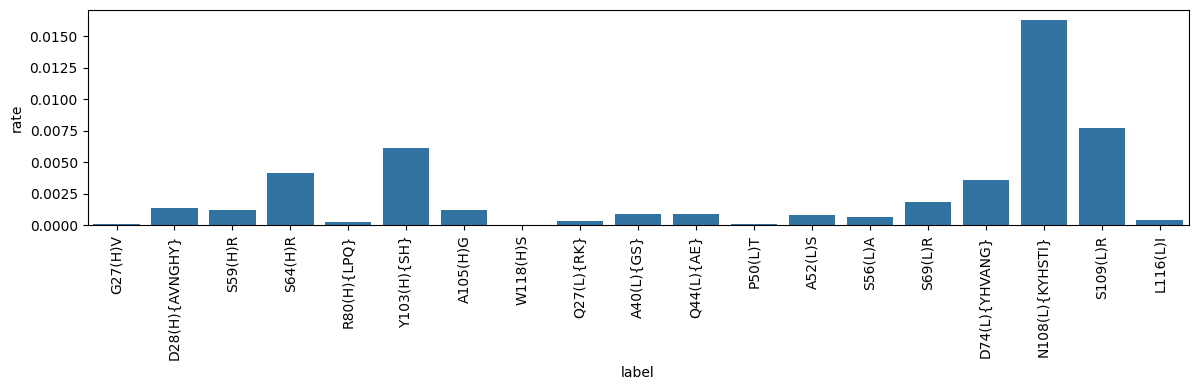

In [17]:
# make a barplot of rate in plot_df with "label" on the x-axis and "rate" on the y-axis
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=plot_df, x="label", y="rate", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

In [18]:
plot_df.sort_values("rate")

,label,rate
7,W118(H)S,0.000039
0,G27(H)V,0.000075
11,P50(L)T,0.000146
4,R80(H){LPQ},0.000271
8,Q27(L){RK},0.000368
18,L116(L)I,0.000438
13,S56(L)A,0.000626
12,A52(L)S,0.000845
10,Q44(L){AE},0.000878
9,A40(L){GS},0.000890
